In [ ]:
#Esta es una obra derivada del original escrito por Isabelle Tingzon
# Bibliotecas estándar
import os
import random
from tqdm.notebook import tqdm
import torch

# Manipulación y visualización de datos
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np

# Bibliotecas de aprendizaje profundo
import torch
import torchvision
import torchsummary
from torch.utils import data
from torchvision import datasets, models, transforms

# Fijar semilla para reproducibilidad
SEMILLA = 42
np.random.seed(SEMILLA)



In [ ]:
# Verificar si la GPU está habilitada
dispositivo = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Dispositivo: {}".format(dispositivo))

# Obtener modelo específico de GPU
if str(dispositivo) == "cuda:0":
    print("GPU: {}".format(torch.cuda.get_device_name(0)))

# Montar Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Descargar y preparar datos
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip -O EuroSAT.zip
!unzip -q EuroSAT.zip -d 'EuroSAT/'
!rm EuroSAT.zip

# Transformaciones de datos
tam_entrada = 224
media_imagenet, std_imagenet = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

transformacion_entrenamiento = transforms.Compose([
    transforms.RandomResizedCrop(tam_entrada),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(media_imagenet, std_imagenet)
])

transformacion_validacion = transforms.Compose([
    transforms.Resize(tam_entrada),
    transforms.CenterCrop(tam_entrada),
    transforms.ToTensor(),
    transforms.Normalize(media_imagenet, std_imagenet)
])

transformacion_prueba = transforms.Compose([
    transforms.Resize(tam_entrada),
    transforms.CenterCrop(tam_entrada),
    transforms.ToTensor(),
    transforms.Normalize(media_imagenet, std_imagenet)
])

# Cargar el dataset
ruta_datos = './EuroSAT/2750/'
conjunto_entrenamiento = datasets.ImageFolder(
    ruta_datos, transform=transformacion_entrenamiento)
conjunto_validacion = datasets.ImageFolder(
    ruta_datos, transform=transformacion_validacion)
conjunto_prueba = datasets.ImageFolder(
    ruta_datos, transform=transformacion_prueba)

# Obtener las categorías
nombres_clases = conjunto_entrenamiento.classes
print("Nombres de clases: {}".format(nombres_clases))
print("Número total de clases: {}".format(len(nombres_clases)))

# Dividir aleatoriamente los datos
tam_entrenamiento = 0.70
tam_validacion = 0.15
tam_prueba = 1 - tam_entrenamiento - tam_validacion

indices = list(range(len(conjunto_entrenamiento)))
np.random.shuffle(indices)

tam_split_entrenamiento = int(tam_entrenamiento * len(indices))
tam_split_validacion = int(tam_validacion * len(indices))

indices_entrenamiento = indices[:tam_split_entrenamiento]
indices_validacion = indices[tam_split_entrenamiento:tam_split_entrenamiento + tam_split_validacion]
indices_prueba = indices[tam_split_entrenamiento + tam_split_validacion:]

datos_entrenamiento = data.Subset(conjunto_entrenamiento, indices_entrenamiento)
datos_validacion = data.Subset(conjunto_validacion, indices_validacion)
datos_prueba = data.Subset(conjunto_prueba, indices_prueba)

print("Tamaños de entrenamiento/validación/prueba: {}/{}/{}".format(
    len(datos_entrenamiento), len(datos_validacion), len(datos_prueba)
))

# Crear DataLoaders
tam_lote = 16
trabajadores = 2

carga_entrenamiento = data.DataLoader(
    datos_entrenamiento, batch_size=tam_lote, num_workers=trabajadores, shuffle=True
)
carga_validacion = data.DataLoader(
    datos_validacion, batch_size=tam_lote, num_workers=trabajadores, shuffle=False
)
carga_prueba = data.DataLoader(
    datos_prueba, batch_size=tam_lote, num_workers=trabajadores, shuffle=False
)



Dispositivo: cuda:0
GPU: Tesla T4
Mounted at /content/drive
--2024-11-27 19:29:49--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M   102MB/s    in 0.9s    

2024-11-27 19:29:50 (102 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]

Nombres de clases: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Número total de clases: 10
Tamaños de entrenamiento/validación/prueba: 18900/4050/4050


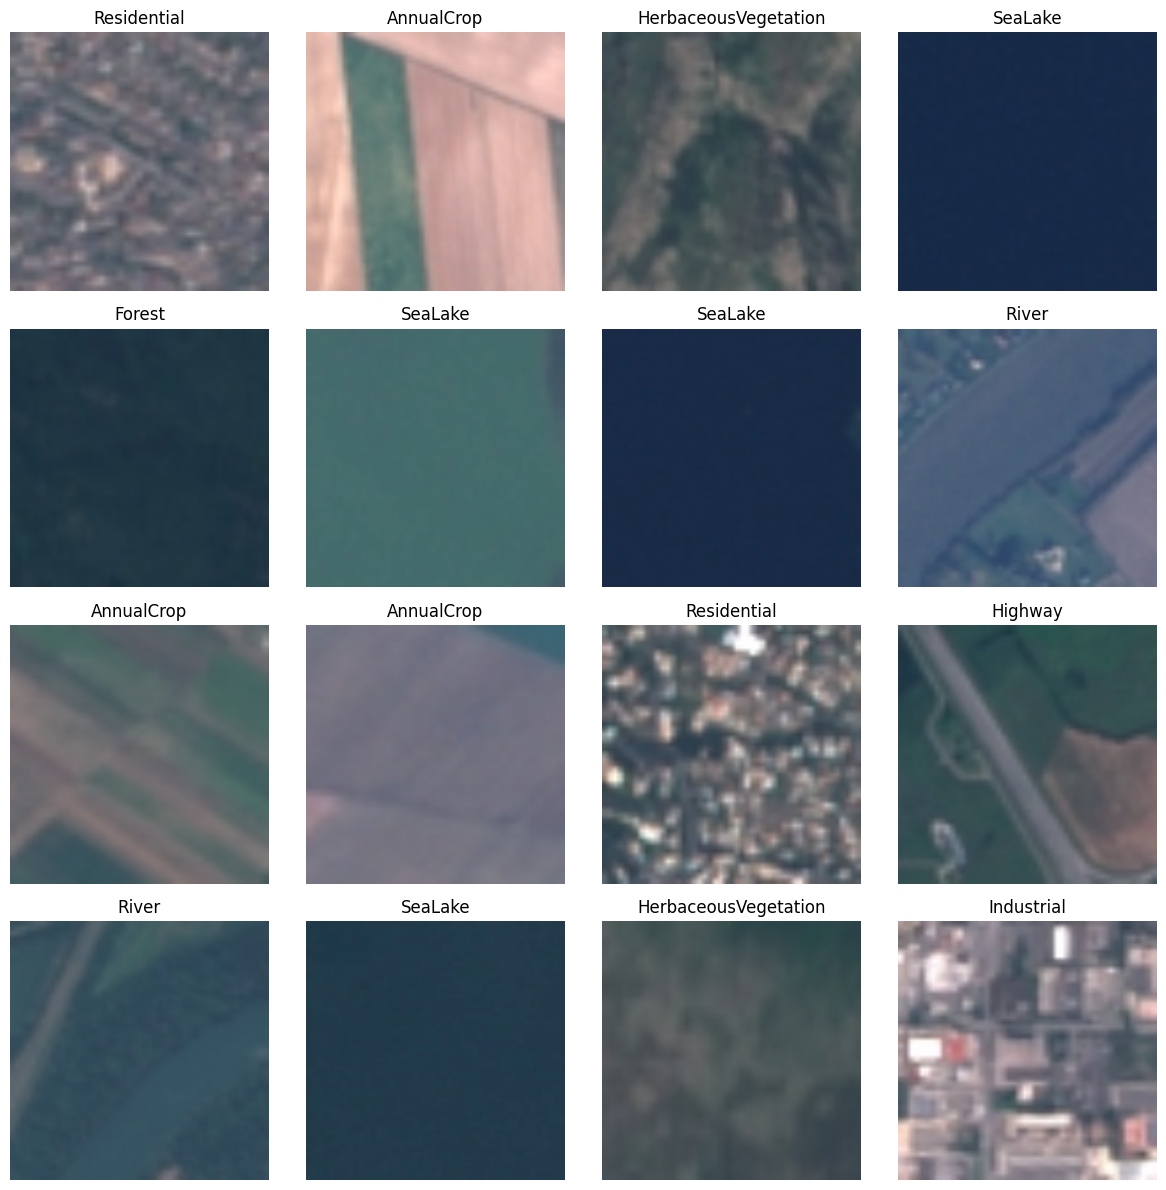

In [ ]:
# Visualizar datos
n = 4  # Cambia n para ajustar la cuadrícula a 4x4
lote = next(iter(carga_entrenamiento))
entradas, clases = lote
figura, ejes = plt.subplots(n, n, figsize=(12, 12))  # Cambia el tamaño para una cuadrícula más grande

for i in range(n):
    for j in range(n):
        indice = i * n + j  # Índice para acceder a las imágenes en el lote
        if indice < len(entradas):  # Asegúrate de no acceder fuera del rango del lote
            imagen = entradas[indice].numpy().transpose((1, 2, 0))
            imagen = np.clip(np.array(std_imagenet) * imagen + np.array(media_imagenet), 0, 1)
            ejes[i, j].imshow(imagen)
            ejes[i, j].set_title(nombres_clases[clases[indice]])
            ejes[i, j].axis('off')
plt.tight_layout()
plt.show()



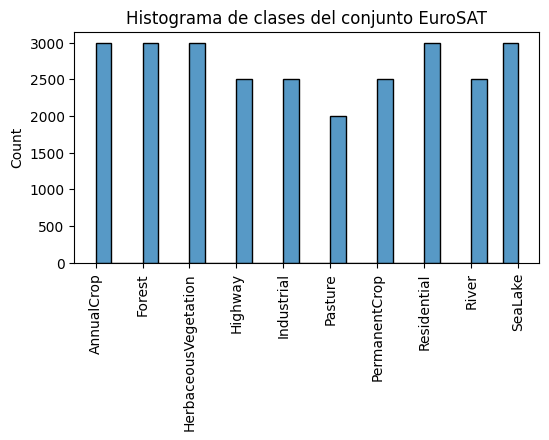

In [ ]:
# Análisis exploratorio de datos
plt.figure(figsize=(6, 3))
histograma = sns.histplot([clase for _, clase in conjunto_entrenamiento])

histograma.set_xticks(range(len(nombres_clases)))
histograma.set_xticklabels(nombres_clases, rotation=90)
histograma.set_title('Histograma de clases del conjunto EuroSAT')
plt.show()


In [ ]:
# Configuración del modelo
modelo = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
modelo.fc = torch.nn.Linear(modelo.fc.in_features, len(nombres_clases))
modelo = modelo.to(dispositivo)

torchsummary.summary(modelo, (3, tam_entrada, tam_entrada))

# Especificar número de épocas y tasa de aprendizaje
numero_epocas = 10
tasa_aprendizaje = 1e-3

# Especificar criterio y optimizador
criterio = torch.nn.CrossEntropyLoss()
optimizador = torch.optim.SGD(modelo.parameters(), lr=tasa_aprendizaje)



Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 72.2MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# Definir función de entrenamiento
def entrenar(modelo, cargador_datos, criterio, optimizador):
    modelo.train()

    perdida_acumulada = 0.0
    total_correctos = 0.0

    for i, (entradas, etiquetas) in enumerate(tqdm(cargador_datos)):
        entradas = entradas.to(dispositivo)
        etiquetas = etiquetas.to(dispositivo)

        # Reiniciar gradientes
        optimizador.zero_grad()

        # Paso hacia adelante
        salidas = modelo(entradas)

        # Calcular pérdida
        perdida = criterio(salidas, etiquetas)

        # Propagar gradientes
        perdida.backward()

        # Actualizar pesos
        optimizador.step()

        # Calcular estadísticas
        _, predicciones = torch.max(salidas, 1)
        perdida_acumulada += perdida.item() * entradas.size(0)
        total_correctos += torch.sum(predicciones == etiquetas)

    # Calcular pérdida y precisión por época
    perdida_epoca = perdida_acumulada / len(cargador_datos.dataset)
    precision_epoca = (total_correctos / len(cargador_datos.dataset)) * 100
    print(f"Perdida de entrenamiento: {perdida_epoca:.2f}; Precisión: {precision_epoca:.2f}%")

    return perdida_epoca, precision_epoca

# Definir función de evaluación
def evaluar(modelo, cargador_datos, criterio, fase="validacion"):
    modelo.eval()

    perdida_acumulada = 0.0
    total_correctos = 0.0

    for i, (entradas, etiquetas) in enumerate(tqdm(cargador_datos)):
        entradas = entradas.to(dispositivo)
        etiquetas = etiquetas.to(dispositivo)

        with torch.set_grad_enabled(False):
            salidas = modelo(entradas)
            perdida = criterio(salidas, etiquetas)
            _, predicciones = torch.max(salidas, 1)

        perdida_acumulada += perdida.item() * entradas.size(0)
        total_correctos += torch.sum(predicciones == etiquetas)

    # Calcular pérdida y precisión por época
    perdida_epoca = perdida_acumulada / len(cargador_datos.dataset)
    precision_epoca = (total_correctos / len(cargador_datos.dataset)) * 100
    print(f"{fase.title()} Perdida: {perdida_epoca:.2f}; Precisión: {precision_epoca:.2f}%")

    return perdida_epoca, precision_epoca

# Definir función de ajuste (entrenamiento y evaluación)
def ajustar(modelo, cargador_entrenamiento, cargador_validacion, numero_epocas, criterio, optimizador):
    mejor_perdida = float('inf')
    mejor_modelo = None

    for epoca in range(numero_epocas):
        print(f"Época {epoca + 1}")

        # Entrenar
        entrenar(modelo, cargador_entrenamiento, criterio, optimizador)

        # Evaluar
        perdida_validacion, _ = evaluar(modelo, cargador_validacion, criterio, fase="validacion")

        if perdida_validacion < mejor_perdida:
            mejor_perdida = perdida_validacion
            mejor_modelo = modelo

    return mejor_modelo


In [ ]:
# Comenzar entrenamiento y evaluación
mejor_modelo = ajustar(modelo, carga_entrenamiento, carga_validacion, numero_epocas, criterio, optimizador)


Época 1


  0%|          | 0/1182 [00:00<?, ?it/s]

Perdida de entrenamiento: 1.66; Precisión: 51.87%


  0%|          | 0/254 [00:00<?, ?it/s]

Validacion Perdida: 1.20; Precisión: 71.51%
Época 2


  0%|          | 0/1182 [00:00<?, ?it/s]

Perdida de entrenamiento: 0.94; Precisión: 72.32%


  0%|          | 0/254 [00:00<?, ?it/s]

Validacion Perdida: 0.70; Precisión: 83.06%
Época 3


  0%|          | 0/1182 [00:00<?, ?it/s]

Perdida de entrenamiento: 0.71; Precisión: 77.38%


  0%|          | 0/254 [00:00<?, ?it/s]

Validacion Perdida: 0.52; Precisión: 84.99%
Época 4


  0%|          | 0/1182 [00:00<?, ?it/s]

Perdida de entrenamiento: 0.58; Precisión: 81.29%


  0%|          | 0/254 [00:00<?, ?it/s]

Validacion Perdida: 0.34; Precisión: 90.17%
Época 5


  0%|          | 0/1182 [00:00<?, ?it/s]

Perdida de entrenamiento: 0.51; Precisión: 83.18%


  0%|          | 0/254 [00:00<?, ?it/s]

Validacion Perdida: 0.27; Precisión: 92.02%
Época 6


  0%|          | 0/1182 [00:00<?, ?it/s]

Perdida de entrenamiento: 0.47; Precisión: 84.61%


  0%|          | 0/254 [00:00<?, ?it/s]

Validacion Perdida: 0.24; Precisión: 93.53%
Época 7


  0%|          | 0/1182 [00:00<?, ?it/s]

Perdida de entrenamiento: 0.43; Precisión: 85.82%


  0%|          | 0/254 [00:00<?, ?it/s]

Validacion Perdida: 0.20; Precisión: 94.25%
Época 8


  0%|          | 0/1182 [00:00<?, ?it/s]

Perdida de entrenamiento: 0.39; Precisión: 86.97%


  0%|          | 0/254 [00:00<?, ?it/s]

Validacion Perdida: 0.35; Precisión: 88.52%
Época 9


  0%|          | 0/1182 [00:00<?, ?it/s]

Perdida de entrenamiento: 0.38; Precisión: 87.82%


  0%|          | 0/254 [00:00<?, ?it/s]

Validacion Perdida: 0.17; Precisión: 94.86%
Época 10


  0%|          | 0/1182 [00:00<?, ?it/s]

Perdida de entrenamiento: 0.37; Precisión: 87.95%


  0%|          | 0/254 [00:00<?, ?it/s]

Validacion Perdida: 0.15; Precisión: 95.36%


In [ ]:
# Evaluar el modelo en el conjunto de prueba
perdida_prueba, _ = evaluar(mejor_modelo, carga_prueba, criterio, fase="prueba")


  0%|          | 0/254 [00:00<?, ?it/s]

Prueba Perdida: 0.17; Precisión: 94.86%


In [ ]:
# Guardar modelo
directorio_modelo = "./drive/My Drive/Colab Notebooks/modelos/"
if not os.path.exists(directorio_modelo):
    os.makedirs(directorio_modelo)

archivo_modelo = os.path.join(directorio_modelo, 'mejor_modelo.pth')
torch.save(mejor_modelo.state_dict(), archivo_modelo)
print(f"Modelo guardado exitosamente en {archivo_modelo}")

# Cargar modelo guardado
def cargar_modelo(archivo_modelo):
    modelo = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    modelo.fc = torch.nn.Linear(modelo.fc.in_features, len(nombres_clases))
    modelo.load_state_dict(torch.load(archivo_modelo))
    modelo.eval()
    print(f"Modelo cargado desde {archivo_modelo}")
    return modelo

modelo_cargado = cargar_modelo(archivo_modelo)


Modelo guardado exitosamente en ./drive/My Drive/Colab Notebooks/modelos/mejor_modelo.pth


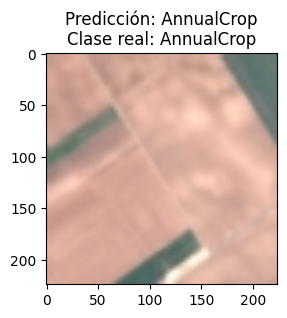

In [ ]:
# Visualizar resultados en una muestra
indice = 15
imagen, etiqueta = datos_prueba[indice]

# Predicción
modelo_cargado.to("cpu")
salida = modelo_cargado(imagen.unsqueeze(0))
_, prediccion = torch.max(salida, 1)

# Mostrar resultado
etiqueta_real = nombres_clases[etiqueta]
etiqueta_prediccion = nombres_clases[prediccion[0]]

imagen = imagen.numpy().transpose((1, 2, 0))
imagen = np.clip(np.array(std_imagenet) * imagen + np.array(media_imagenet), 0, 1)

figura, eje = plt.subplots(figsize=(3, 3))
eje.imshow(imagen)
eje.set_title(f"Predicción: {etiqueta_prediccion}\nClase real: {etiqueta_real}")
plt.show()


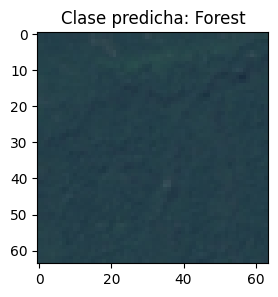

In [ ]:
# Ejecutar el modelo en una imagen PIL
from PIL import Image

ruta_imagen = './EuroSAT/2750/Forest/Forest_2.jpg'
imagen = Image.open(ruta_imagen)

# Transformar imagen
entrada = transformacion_prueba(imagen)

# Predicción
salida = modelo_cargado(entrada.unsqueeze(0))
_, prediccion = torch.max(salida, 1)

# Obtener etiqueta
etiqueta_prediccion = nombres_clases[prediccion[0]]

# Visualizar resultado
figura, eje = plt.subplots(figsize=(3, 3))
eje.imshow(imagen)
eje.set_title(f"Clase predicha: {etiqueta_prediccion}")
plt.show()
